## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from langdetect import detect
from deep_translator import GoogleTranslator
import re
from nltk.corpus import stopwords

In [2]:
df_train = pd.read_table('/Users/anthi/Desktop/cw/dataset/mediaeval-2015-trainingset.txt', sep="\t",lineterminator='\n',  header= 0)
df_test = pd.read_table('/Users/anthi/Desktop/cw/dataset/mediaeval-2015-testset.txt', sep="\t",lineterminator='\n',  header= 0)

In [3]:
df_train.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


so we have a ratio of about 80/20 between the train and test dataset

In [6]:
df_train.rename(columns={'imageId(s)': 'imageid'}, inplace = True)
df_test.rename(columns={'imageId(s)': 'imageid'}, inplace = True)

### Counting Duplicates

In [7]:
print('train duplicates: ' + str(df_train['tweetText'].duplicated().sum()))

train duplicates: 1901


### Fake/humor bias

In [8]:
df_train['label'].isin(['fake', 'humor']).sum(axis=0)

9356

In [9]:
df_train['label'].isin(['real']).sum(axis=0)

4921

In [10]:
df_test['label'].isin(['fake', 'humor']).sum(axis=0)

2546

In [11]:
df_test['label'].isin(['real']).sum(axis=0)

1209

### Frequent events based on image names

In [12]:
image_counter = df_train.groupby(df_train['imageid'].str.split('_').str[0])['tweetId'].nunique()
image_counter = image_counter.sort_values(ascending=False)
print (image_counter)

imageid
sandyA                9695
sandyB                2621
boston                 546
malaysia               501
sochi                  402
columbianChemicals     185
bringback              131
underwater             112
passport                46
pigFish                 14
elephant                13
livr                     9
Name: tweetId, dtype: int64


In [13]:
fig = px.bar(x=list(image_counter.keys()), y=(image_counter), labels={'x':'Image Id','y':'Frequency'}, title='Most Common Image Id (Train)')
fig.write_image("images/image_common_train.png")
fig.show()

In [14]:
image_counter1 = df_test.groupby(df_test['imageid'].str.split('_').str[0])['tweetId'].nunique()
image_counter1 = image_counter1.sort_values(ascending=False)
print (image_counter1)

imageid
syrianboy     1769
nepal         1353
eclipse        277
samurai        218
garissa         77
varoufakis      61
Name: tweetId, dtype: int64


In [15]:
fig = px.bar(x=list(image_counter1.keys()), y=(image_counter1), labels={'x':'Image Id','y':'Frequency'}, title='Most Common Image Id (Test)')
fig.write_image("images/image_common_test.png")
fig.show()

In [16]:
train_tweet_count = Counter()
for text in df_train.tweetText:
    for word in text.split():
        train_tweet_count[word] += 1
        
# freq = [w for (w, wc) in train_tweet_count.most_common(100)]
# print(freq)
print(train_tweet_count.most_common(100))

[('#Sandy', 3402), ('the', 3234), ('#sandy', 2901), ('of', 2646), ('in', 2493), ('Sandy', 2248), ('is', 1601), ('RT', 1499), ('a', 1489), ('New', 1262), ('Hurricane', 1229), ('de', 1211), ('to', 1064), ('this', 980), ('#hurricanesandy', 913), ('#hurricane', 796), ('This', 726), ('from', 721), ('for', 675), ('York', 629), ('on', 609), ('photo', 607), ('at', 596), ('#HurricaneSandy', 564), ('and', 553), ('la', 534), ('The', 517), ('sandy', 512), ('I', 507), ('hurricane', 507), ('#NYC', 493), ('are', 490), ('A', 467), ('en', 451), ('cover', 450), ('#nyc', 426), ('Jersey', 406), ('you', 405), ('NYC', 380), ('out', 376), ('Tomb', 369), ('Sandy.', 362), ('during', 361), ('was', 347), ('by', 342), ('my', 336), ('-', 332), ('#newyork', 328), ('that', 322), ('real', 321), ('Unknown', 317), ('que', 315), ('el', 311), ('picture', 295), ('del', 294), ('like', 292), ('shark', 291), ('MH370', 291), ('swimming', 287), ('with', 286), ('pic', 274), ('be', 271), ('#Hurricane', 262), ('about', 257), ('no

In [17]:
import kaleido

common_words = dict(train_tweet_count.most_common(20))

fig = px.bar(x=list(common_words.keys()), y=list(common_words.values()), labels={'x':'Words','y':'Frequency'}, title='Most Common Words (Train)')
fig.write_image("images/common_train.png")
fig.show()

In [18]:
test_tweet_count = Counter()

for text in df_test.tweetText:
    for word in text.split():
        test_tweet_count[word] += 1
        
# freq = [w for (w, wc) in test_tweet_count.most_common(100)]
# print(freq)
print(test_tweet_count.most_common(100))

[('in', 2791), ('girl', 1658), ('rescue', 1489), ('HERO', 1460), ('BOY', 1420), ('SYRIAN', 1378), ('SYRIA!', 1226), ('Dharahara', 1149), ('historic', 1096), ('shootout.', 878), ("Nepal's", 806), ('السوري', 803), ('Tower', 780), ('collapses', 767), ('massive', 766), ('الصبي', 652), ('SEE', 633), ('THIS!!', 622), ('a', 547), ('earthquake', 486), ('to', 474), ('البطل', 470), ('shootout', 461), ('@YouTube', 460), ('Syrian', 441), ('the', 414), ('The', 401), ('via', 368), ('of', 362), ('#NepalEarthquake', 334), ('-', 311), ('earthquake:', 298), ('الطفل', 275), ('tower,', 267), ('...', 259), ('landmark', 235), ('S…:', 235), ('from', 222), ('Girl', 194), ('ISS', 189), ('sniper', 185), ('fire', 173), ('Photo', 166), ("'Samurai", 162), ('de', 159), ('Mysterious', 156), ("Ghost':", 153), ('video', 152), ('البطل:', 151), ("'hero", 145), ("boy'", 145), ('terrified', 144), ('eclipse', 143), ('brave', 140), ('and', 139), ('Shows', 138), ('Boots', 137), ('Behind', 137), ('appears', 135), ('Watch:', 1

In [19]:
common_words = dict(test_tweet_count.most_common(20))

fig = px.bar(x=list(common_words.keys()), y=list(common_words.values()), labels={'x':'Words','y':'Frequency'}, title='Most Common Words (Test)')
fig.write_image("images/common_test.png")
fig.show()

In [20]:
length_data = df_train['tweetText'].str.len()
fig = px.histogram(x=length_data, template='plotly_dark', title='Length of tweets')
fig.update_xaxes(categoryorder='category descending', title='Length').update_yaxes(title='Tweets')
fig.show()

In [21]:
fig = px.box(x=length_data, template='plotly_dark', title='Length of tweets')
fig.show()

so over 237 characters it's and outlier

In [22]:
df_train['label'] = df_train['label'].map({'real': 0, 'fake': 1, 'humor': 1})
df_test['label'] = df_test['label'].map({'real': 0, 'fake': 1, 'humor': 1})

In [23]:
real = df_train[df_train['label']==0]
fig = px.histogram(real, x='imageid', template='plotly_dark', title='Real tweet count per imageId')
fig.update_xaxes(categoryorder='category descending', title='Image Id').update_yaxes(title='Number of tweets')
fig.show()

In [24]:
f_h = df_train[df_train['label']==1]
fig = px.histogram(f_h, x='imageid', template='plotly_dark', title='Fake/humor tweet count per imageId')
fig.update_xaxes(categoryorder='category descending', title='Image Id').update_yaxes(title='Number of tweets')
fig.show()

In [25]:
df_train = df_train[df_train['tweetText'].str.len()<240]

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14262 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetId    14262 non-null  int64 
 1   tweetText  14262 non-null  object
 2   userId     14262 non-null  int64 
 3   imageid    14262 non-null  object
 4   username   14262 non-null  object
 5   timestamp  14262 non-null  object
 6   label      14262 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 891.4+ KB


In [27]:
def detect_language(x):
    try:
        return detect(x)
    except:
        return "unknown"

language = df_train['tweetText'].apply(detect_language)
language_test = df_test['tweetText'].apply(detect_language)

In [28]:
language.value_counts()

en         10949
es          1297
tl           312
fr           214
id           182
pt           161
de           124
so           120
cy           116
it            96
nl            88
ar            80
af            67
ru            60
sv            44
no            43
pl            39
ca            36
tr            32
da            26
ja            21
th            19
sk            13
et            13
fi            13
vi            12
zh-cn          9
sq             8
bg             8
ro             8
sl             8
sw             8
ko             6
hu             6
lt             5
el             5
hr             5
fa             3
he             1
unknown        1
cs             1
mk             1
hi             1
lv             1
Name: tweetText, dtype: int64

In [29]:
language_test.value_counts()

en    2775
so     514
ar     180
es      60
de      41
pt      39
fr      33
nl      21
it      18
tr      13
ca       7
id       6
af       5
sq       5
hi       5
cy       5
fi       4
tl       2
th       2
ja       2
vi       2
bg       2
el       2
te       2
pl       2
sv       1
ru       1
ko       1
et       1
ta       1
lt       1
hr       1
da       1
Name: tweetText, dtype: int64

In [30]:
language.info()

<class 'pandas.core.series.Series'>
Int64Index: 14262 entries, 0 to 14276
Series name: tweetText
Non-Null Count  Dtype 
--------------  ----- 
14262 non-null  object
dtypes: object(1)
memory usage: 222.8+ KB


In [31]:
fig = px.histogram(x=language, template='plotly_dark', title='Tweet counts by language')
fig.update_xaxes(categoryorder='category descending', title='Language').update_yaxes(title='Number of tweets')
fig.write_image("images/languages.png")
fig.show()

## Preprocessing

In [32]:
# def translate_text(t):
#     return GoogleTranslator(source='auto', target='en').translate(t)

# df_train['text_translate'] = df_train['tweetText'].apply(translate_text)

In [33]:
# df_train['text_translate'].head()

In [34]:
# df_keep = df_train

In [35]:
df_train.drop_duplicates(subset=['tweetText'], keep='first', inplace=True, ignore_index = False)

In [36]:
df_train_no_rt = df_train

retweet_pat = "RT|rt|MT|mt|RP|rp|#rt|#RT|#mt|#MT|#rp|#retweet|#Retweet|#modifiedtweet|#modifiedTweet|#ModifiedTweet|#repost|#Repost|\bRT\b|\brt\b|\bMT\b|\bmt\b|\bRP\b|\brp\b"
rt = df_train_no_rt['tweetText'].str.contains(retweet_pat)

df_train_no_rt = df_train_no_rt[~rt]

In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12361 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetId    12361 non-null  int64 
 1   tweetText  12361 non-null  object
 2   userId     12361 non-null  int64 
 3   imageid    12361 non-null  object
 4   username   12361 non-null  object
 5   timestamp  12361 non-null  object
 6   label      12361 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 772.6+ KB


In [38]:
df_train_no_rt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9501 entries, 2 to 14276
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweetId    9501 non-null   int64 
 1   tweetText  9501 non-null   object
 2   userId     9501 non-null   int64 
 3   imageid    9501 non-null   object
 4   username   9501 non-null   object
 5   timestamp  9501 non-null   object
 6   label      9501 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 593.8+ KB


In [39]:
def preprocessing(x):
    # x=x.lower()
    x=re.sub("#", " ", x)
    x=re.sub("[^a-zA-Z ]+", "", x)
    # x=re.sub(r'@\w*', "", x)
    x=re.sub(r"&amp;|\\n", "", x)
    # x=re.sub(r"\\\/\S+", "", x)
    # x=re.sub(r"http\S+", "", x)
    return x

df_train['refined_text'] = df_train['tweetText'].apply(preprocessing)
df_train_no_rt['refined_text'] = df_train_no_rt['tweetText'].apply(preprocessing)
# df_keep['refined_text'] = df_keep['tweetText'].apply(preprocessing)
df_test['refined_text'] = df_test['tweetText'].apply(preprocessing)
# df_train['refined_tr_text'] = df_train['text_translate'].apply(preprocessing)


/var/folders/5s/ph73x81x4cl5c6f4k6k6t_th0000gn/T/ipykernel_80066/3301374600.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
df_train[['tweetText', 'refined_text', 'label']].sample(20)

,tweetText,refined_text,label
9723,Wow! #Sandy RT @DianeSawyer: Pretty incredibl...,Wow Sandy RT DianeSawyer Pretty incredible I...,0
2971,"Estoy flipando, el huracán Sandy lleva tiburon...",Estoy flipando el huracn Sandy lleva tiburones...,1
7136,#HurricaneSandy tryna compete w/her sister #Ka...,HurricaneSandy tryna compete wher sister Kat...,1
4008,Used to have a house in Brigantine. This is un...,Used to have a house in Brigantine This is unr...,1
12598,#boston #Coward #Manhunt #looser #Bomber http:...,boston Coward Manhunt looser Bomber httpt...,0
11169,My friend's picture - there ARE nice people in...,My friends picture there ARE nice people in t...,0
3115,"If ur gonna make a fake hurricane sandy pic, d...",If ur gonna make a fake hurricane sandy pic do...,1
5472,Hurricane Sandy got everybody hiding. Lol haha...,Hurricane Sandy got everybody hiding Lol hahah...,1
1222,#oh #god #shark #swimming #on #street #amazing...,oh god shark swimming on street amazing...,1
13589,Sochi bathrooms so private... http://t.co/JPYO...,Sochi bathrooms so private httptcoJPYOVgohBZ,1


In [41]:
len_ref = df_train['refined_text'].str.len()
fig = px.histogram(x=len_ref, template='plotly_dark', title='Length of tweets')
fig.update_xaxes(categoryorder='category descending', title='Length of tweets (refined)').update_yaxes(title='Tweets')
fig.update_layout(xaxis_range=[0,60])
fig.show()

In [42]:
len_ref_rt = df_train_no_rt['refined_text'].str.len()
fig = px.histogram(x=len_ref_rt, template='plotly_dark', title='Length of tweets (no rt)')
fig.update_xaxes(categoryorder='category descending', title='Length of tweets (refined)').update_yaxes(title='Tweets')
fig.update_layout(xaxis_range=[0,60])
fig.show()

In [43]:
df_train['refined_text'] = df_train['refined_text'].apply(lambda text: " ".join(text.split()))
# df_keep['refined_text'] = df_keep['refined_text'].apply(lambda text: " ".join(text.split()))
df_train_no_rt['refined_text'] = df_train_no_rt['refined_text'].apply(lambda text: " ".join(text.split()))
df_test['refined_text'] = df_test['refined_text'].apply(lambda text: " ".join(text.split()))

/var/folders/5s/ph73x81x4cl5c6f4k6k6t_th0000gn/T/ipykernel_80066/3576747461.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
real_tweet_count = Counter()
for text in df_train[df_train['label'] == 0].refined_text:
    for word in text.split():
        real_tweet_count[word] += 1
        
# freq = [w for (w, wc) in real_tweet_count.most_common(100)]
# print(freq)
print(real_tweet_count.most_common(100))

[('Sandy', 1794), ('sandy', 1157), ('the', 804), ('of', 788), ('in', 740), ('RT', 657), ('is', 452), ('New', 378), ('a', 373), ('NYC', 335), ('hurricane', 323), ('to', 323), ('photo', 322), ('Hurricane', 313), ('this', 296), ('hurricanesandy', 291), ('York', 290), ('from', 273), ('cover', 270), ('This', 257), ('for', 233), ('via', 227), ('de', 209), ('and', 200), ('Manhattan', 197), ('on', 179), ('NJ', 179), ('A', 175), ('The', 174), ('nyc', 171), ('are', 168), ('Magazine', 166), ('at', 162), ('Boston', 161), ('out', 153), ('people', 145), ('you', 138), ('with', 137), ('down', 132), ('by', 131), ('I', 121), ('HurricaneSandy', 120), ('suspect', 120), ('after', 118), ('Jersey', 111), ('about', 110), ('will', 106), ('go', 103), ('Wow', 102), ('who', 102), ('Obama', 102), ('City', 99), ('NY', 98), ('storm', 97), ('Hoboken', 91), ('la', 91), ('over', 91), ('en', 89), ('my', 89), ('water', 87), ('that', 87), ('NYMag', 86), ('kind', 86), ('Amazing', 85), ('Thank', 85), ('SANDY', 84), ('needs'

In [45]:
common_words = dict(real_tweet_count.most_common(30))

fig = px.bar(x=list(common_words.keys()), y=list(common_words.values()), labels={'x':'Words','y':'Frequency'}, title='Most Common Words')
fig.show()

In [46]:
fake_tweet_count = Counter()
for text in df_train[df_train['label'] == 1].refined_text:
    for word in text.split():
        fake_tweet_count[word] += 1
        
# freq = [w for (w, wc) in fake_tweet_count.most_common(100)]
# print(freq)

print(fake_tweet_count.most_common(100))

[('Sandy', 3749), ('the', 2172), ('sandy', 2070), ('of', 1532), ('in', 1411), ('Hurricane', 1012), ('hurricane', 977), ('is', 946), ('a', 912), ('de', 825), ('New', 752), ('RT', 711), ('this', 658), ('to', 644), ('hurricanesandy', 637), ('NYC', 514), ('HurricaneSandy', 454), ('York', 446), ('Jersey', 414), ('la', 387), ('on', 381), ('Sochi', 375), ('NY', 373), ('at', 373), ('MH', 369), ('for', 367), ('shark', 355), ('Tomb', 350), ('I', 349), ('This', 348), ('from', 319), ('real', 306), ('The', 302), ('en', 295), ('Unknown', 285), ('and', 275), ('pic', 272), ('you', 262), ('during', 257), ('nyc', 253), ('swimming', 253), ('newyork', 251), ('Soldier', 236), ('photo', 235), ('Liberty', 232), ('A', 232), ('was', 231), ('it', 223), ('that', 218), ('my', 217), ('el', 215), ('like', 214), ('que', 212), ('out', 210), ('are', 207), ('huracn', 205), ('storm', 198), ('picture', 198), ('del', 194), ('be', 194), ('ColumbianChemicals', 181), ('got', 175), ('SANDY', 175), ('no', 172), ('foto', 162), 

In [47]:
common_words = dict(fake_tweet_count.most_common(20))

fig = px.bar(x=list(common_words.keys()), y=list(common_words.values()), labels={'x':'Words','y':'Frequency'}, title='Most Common Words')
fig.show()

In [48]:
# df_keep.info()

In [49]:
stopwordsstr = stopwords.words()
stopwordseng = stopwords.words('english')

In [50]:
df_train['refined_text'] = df_train['refined_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwordsstr]))
df_train_no_rt['refined_text'] = df_train_no_rt['refined_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwordsstr]))
# df_keep['refined_text'] = df_keep['refined_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwordsstr]))
df_test['refined_text'] = df_test['refined_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwordsstr]))
# df_train['refined_tr_text'] = df_train['refined_tr_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwordseng]))
# df_test['refined_tr_text'] = df_test['refined_tr_text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwordseng]))

/var/folders/5s/ph73x81x4cl5c6f4k6k6t_th0000gn/T/ipykernel_80066/3321188770.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [51]:
df_train[['tweetText', 'refined_text', 'label']].sample(10)

,tweetText,refined_text,label
10852,RT @AaronM_NZ: Taxi anyone? #Sandy http://t.co...,RT AaronMNZ Taxi Sandy httptcovKBkNmD FB,0
155,shark in brigantine #hurricane #sandy #holys...,shark brigantine hurricane sandy holyshit http...,1
6848,“@whiteboytatted Hurricane sandy be thankful f...,whiteboytatted Hurricane sandy thankful id sav...,1
10280,Amazing RT @BruceFeiler: This New York Magazin...,Amazing RT BruceFeiler This New York Magazine ...,0
6121,"Sandy, devassa!! http://t.co/zcp842LS",Sandy devassa httptcozcpLS,1
7145,My Godfather sent me this pic of the soldiers ...,My Godfather soldiers guarding TomboftheUnknow...,1
6043,Sandy over Ellis Island #manhattan 🗽🌆 http://t...,Sandy Ellis Island manhattan httptcoNHTBvJL,1
300,Tomb of the Unknown Soldier. During #Hurrica...,Tomb Unknown Soldier During Hurricane Sandy Ar...,1
12680,#bostonmarathon #boston here are 2 persons of ...,bostonmarathon boston persons interest fbi spe...,0
841,#sandy #usa #unitedstate #hurcane #weather @ M...,sandy usa unitedstate hurcane weather My Home ...,1


In [52]:
tokenise = nltk.tokenize.WhitespaceTokenizer()
lemmatise = nltk.stem.WordNetLemmatizer()

df_train['tl_text'] = df_train['refined_text'].apply(lambda x: ' '.join([lemmatise.lemmatize(w) for w in tokenise.tokenize(x)]))
df_train_no_rt['tl_text'] = df_train_no_rt['refined_text'].apply(lambda x: ' '.join([lemmatise.lemmatize(w) for w in tokenise.tokenize(x)]))
# df_keep['tl_text'] = df_keep['refined_text'].apply(lambda x: ' '.join([lemmatise.lemmatize(w) for w in tokenise.tokenize(x)]))
df_test['tl_text'] = df_test['refined_text'].apply(lambda x: ' '.join([lemmatise.lemmatize(w) for w in tokenise.tokenize(x)]))

/var/folders/5s/ph73x81x4cl5c6f4k6k6t_th0000gn/T/ipykernel_80066/1816385936.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
df_train_no_rt[['tweetText', 'refined_text', 'tl_text', 'label']].sample(10)

,tweetText,refined_text,tl_text,label
6917,NYC this afternoon... Nature is something else...,NYC afternoon Nature stolen picture facebook h...,NYC afternoon Nature stolen picture facebook h...,1
13062,"#EffectualFerventAndContinue,#PrayerOfARighteo...",EffectualFerventAndContinue PrayerOfARighteous...,EffectualFerventAndContinue PrayerOfARighteous...,1
5203,HEY SANDY!!! STOP PLAYIN!!!! http://t.co/Q1t...,HEY SANDY STOP PLAYIN httptcoQtsrBOA,HEY SANDY STOP PLAYIN httptcoQtsrBOA,1
9039,Insane pic of #Manhattan underwater \n#sandy #...,Insane Manhattan underwater sandy prayers http...,Insane Manhattan underwater sandy prayer httpt...,0
13567,@ThePeterPaige RITWITTA .THESE IMAGES ARE SELL...,ThePeterPaige RITWITTA THESE IMAGES ARE SELLIN...,ThePeterPaige RITWITTA THESE IMAGES ARE SELLIN...,1
12334,Brutal lo que se puede conseguir en colaboraci...,Brutal puede colaboracin Chan analizando fotos...,Brutal puede colaboracin Chan analizando fotos...,1
10863,#applemap #apple #iphone #sandy http://t.co/1F...,applemap apple iphone sandy httptcoFjQ,applemap apple iphone sandy httptcoFjQ,0
10226,@ATVIAssist @GuitarHero Survived Hurricane San...,ATVIAssist GuitarHero Survived Hurricane Sandy...,ATVIAssist GuitarHero Survived Hurricane Sandy...,0
3963,2012 is maybe for real . Sandy mesh 3agbani ya...,real Sandy mesh agbani yamo sandy httptcoWPFAFozD,real Sandy mesh agbani yamo sandy httptcoWPFAFozD,1
9190,One thing worse than raining cats and dogs? Ha...,One worse raining cats dogs Hailing taxis Espe...,One worse raining cat dog Hailing taxi Especia...,0


In [54]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12361 entries, 0 to 14276
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweetId       12361 non-null  int64 
 1   tweetText     12361 non-null  object
 2   userId        12361 non-null  int64 
 3   imageid       12361 non-null  object
 4   username      12361 non-null  object
 5   timestamp     12361 non-null  object
 6   label         12361 non-null  int64 
 7   refined_text  12361 non-null  object
 8   tl_text       12361 non-null  object
dtypes: int64(3), object(6)
memory usage: 965.7+ KB


In [55]:
df_drop = df_train

print(df_drop['label'].isin([1]).sum(axis=0))
print(df_drop['label'].isin([0]).sum(axis=0))

8587
3774


In [56]:
df_drop = df_drop.drop(df_drop[df_drop['label'] == 1].sample(frac=.3).index)

print(df_drop['label'].isin([1]).sum(axis=0))
print(df_drop['label'].isin([0]).sum(axis=0))

6011
3774


In [57]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9785 entries, 0 to 14274
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tweetId       9785 non-null   int64 
 1   tweetText     9785 non-null   object
 2   userId        9785 non-null   int64 
 3   imageid       9785 non-null   object
 4   username      9785 non-null   object
 5   timestamp     9785 non-null   object
 6   label         9785 non-null   int64 
 7   refined_text  9785 non-null   object
 8   tl_text       9785 non-null   object
dtypes: int64(3), object(6)
memory usage: 764.5+ KB


## Classification

In [58]:
x_train = df_train_no_rt['tl_text'] #changed this with the 4 different versions to see what's the best preprocessing method
y_train = df_train_no_rt['label']
x_test = df_test['tl_text']
y_test = df_test['label']

In [59]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix

In [60]:
#Bag-of-Words
count_vectoriser = CountVectorizer(stop_words='english')
count_train = count_vectoriser.fit_transform(x_train)
count_test = count_vectoriser.transform(x_test)

In [61]:
ngram_vectoriser = CountVectorizer(analyzer='char_wb', ngram_range=(2, 2))
ngram_train = ngram_vectoriser.fit_transform(x_train)
ngram_test = ngram_vectoriser.transform(x_test)

In [62]:
tfidf_vectoriser = TfidfVectorizer(stop_words='english', max_df=0.3)
tfidf_train = tfidf_vectoriser.fit_transform(x_train)
tfidf_test = tfidf_vectoriser.transform(x_test)

In [63]:
# clf = MultinomialNB()
classifiers = [MultinomialNB(), BernoulliNB(), SGDClassifier(), RidgeClassifier(), LinearSVC()]

Bag-Of-Words
---------------------------------------------


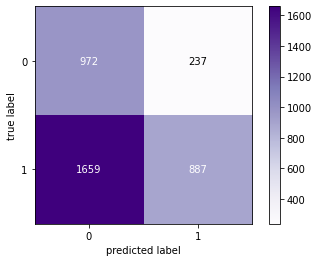

---------------------------------------------
Accuracy:   0.495
F1:   0.483
Precision:   0.789
Recall:   0.348
---------------------------------------------


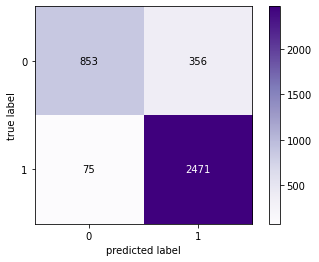

---------------------------------------------
Accuracy:   0.885
F1:   0.920
Precision:   0.874
Recall:   0.971
---------------------------------------------


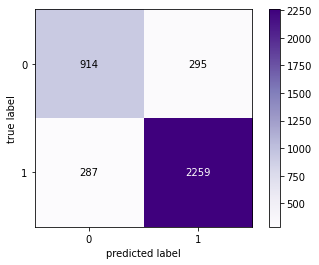

---------------------------------------------
Accuracy:   0.845
F1:   0.886
Precision:   0.884
Recall:   0.887
---------------------------------------------


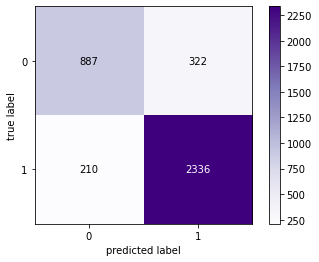

---------------------------------------------
Accuracy:   0.858
F1:   0.898
Precision:   0.879
Recall:   0.918
---------------------------------------------


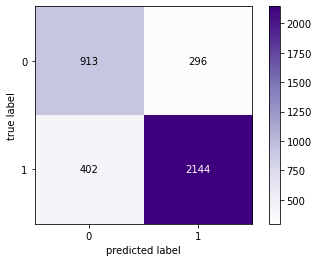

---------------------------------------------
Accuracy:   0.814
F1:   0.860
Precision:   0.879
Recall:   0.842
---------------------------------------------


In [64]:
print('Bag-Of-Words')
print('---------------------------------------------')
for clf in classifiers: 
    clf.fit(count_train, y_train)

    pred = clf.predict(count_test)
    score = metrics.accuracy_score(y_test, pred)
    f1 = metrics.f1_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)

    cm = metrics.confusion_matrix(y_test, pred)

    fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, cmap='Purples')

    name = 'tfidf' + str(clf) + '.png'

    # plt.savefig('images/some_pre/'+name, format='png')

    plt.show()
    
    print('---------------------------------------------')
    print("Accuracy:   %0.3f" % score)
    print("F1:   %0.3f" % f1)
    print("Precision:   %0.3f" % precision)
    print("Recall:   %0.3f" % recall)
    print('---------------------------------------------')

N-Gram
---------------------------------------------


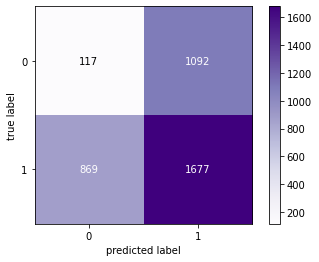

---------------------------------------------
Accuracy:   0.478
F1:   0.631
Precision:   0.606
Recall:   0.659
---------------------------------------------


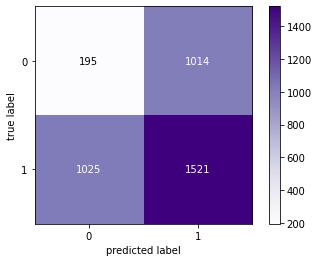

---------------------------------------------
Accuracy:   0.457
F1:   0.599
Precision:   0.600
Recall:   0.597
---------------------------------------------


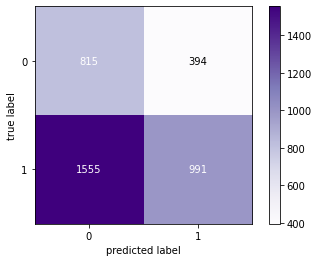

---------------------------------------------
Accuracy:   0.481
F1:   0.504
Precision:   0.716
Recall:   0.389
---------------------------------------------


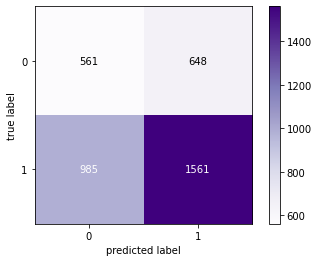

---------------------------------------------
Accuracy:   0.565
F1:   0.657
Precision:   0.707
Recall:   0.613
---------------------------------------------


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



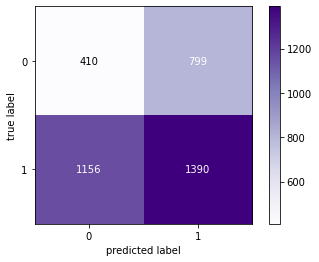

---------------------------------------------
Accuracy:   0.479
F1:   0.587
Precision:   0.635
Recall:   0.546
---------------------------------------------


In [65]:
print('N-Gram')
print('---------------------------------------------')
for clf in classifiers: 
    clf.fit(ngram_train, y_train)

    pred = clf.predict(ngram_test)
    score = metrics.accuracy_score(y_test, pred)
    f1 = metrics.f1_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    cm = metrics.confusion_matrix(y_test, pred)

    fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, cmap='Purples')

    name = 'n-gram' + str(clf) + '.png'

    # plt.savefig('images/some_pre/'+name, format='png')

    plt.show()
    
    print('---------------------------------------------')
    print("Accuracy:   %0.3f" % score)
    print("F1:   %0.3f" % f1)
    print("Precision:   %0.3f" % precision)
    print("Recall:   %0.3f" % recall)
    print('---------------------------------------------')

TF-IDF
---------------------------------------------


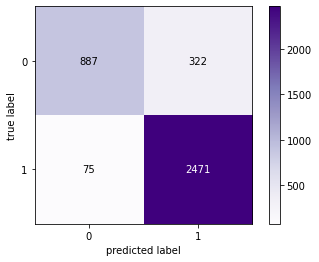

---------------------------------------------
Accuracy:   0.894
F1:   0.926
Precision:   0.885
Recall:   0.971
---------------------------------------------


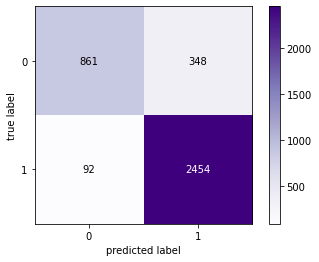

---------------------------------------------
Accuracy:   0.883
F1:   0.918
Precision:   0.876
Recall:   0.964
---------------------------------------------


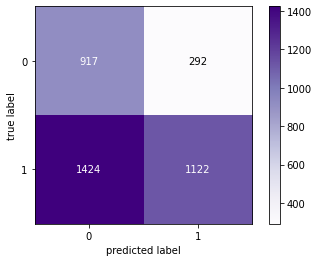

---------------------------------------------
Accuracy:   0.543
F1:   0.567
Precision:   0.793
Recall:   0.441
---------------------------------------------


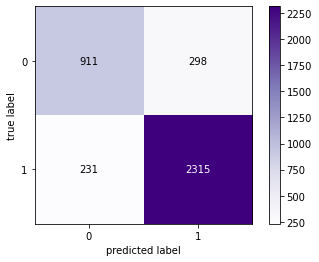

---------------------------------------------
Accuracy:   0.859
F1:   0.897
Precision:   0.886
Recall:   0.909
---------------------------------------------


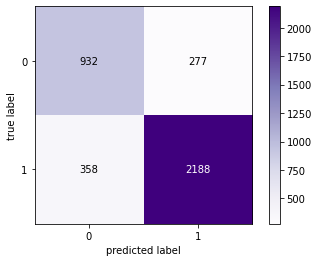

---------------------------------------------
Accuracy:   0.831
F1:   0.873
Precision:   0.888
Recall:   0.859
---------------------------------------------


In [70]:
print('TF-IDF')
print('---------------------------------------------')
for clf in classifiers: 
    clf.fit(tfidf_train, y_train)

    pred = clf.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred)
    f1 = metrics.f1_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    cm = metrics.confusion_matrix(y_test, pred)

    fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, cmap='Purples')

    name = 'tfidf_' + str(clf) + '.png'

    plt.savefig('images/some_pre/'+name, format='png') 

    plt.show()
    
    print('---------------------------------------------')
    print("Accuracy:   %0.3f" % score)
    print("F1:   %0.3f" % f1)
    print("Precision:   %0.3f" % precision)
    print("Recall:   %0.3f" % recall)
    print('---------------------------------------------')

In [67]:
clf = MultinomialNB()
clf.fit(tfidf_train, y_train)

pred = clf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
mnb_f1 = metrics.f1_score(y_test, pred)
mnb_precision = metrics.precision_score(y_test, pred)
mnb_recall = metrics.recall_score(y_test, pred)

mnb_cm = metrics.confusion_matrix(y_test, pred)

print('[Classifier: Multinomial NB]')
print("accuracy: %0.3f" % score)
print("f1 score: %0.3f" % mnb_f1)
print("precision: %0.3f" % mnb_precision)
print("recall: %0.3f" % mnb_recall)

[Classifier: Multinomial NB]
accuracy: 0.894
f1 score: 0.926
precision: 0.885
recall: 0.971


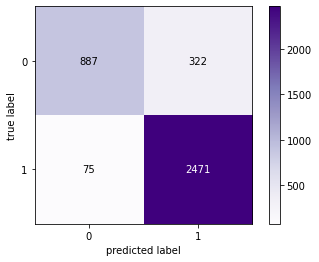

In [68]:
fig, ax = plot_confusion_matrix(conf_mat=mnb_cm, colorbar=True, cmap='Purples')

plt.show()

In [69]:
TP = 0 
FP = 0
TN = 0
FN = 0

for true, guess in zip(y_test, pred):
    if(true == 1 and guess == 1):
        TP = TP + 1
    if(true == 0 and guess == 1):
        FP = FP + 1
    if(true == 0 and guess == 0):
        TN = TN + 1
    if(true == 1 and guess == 0):
        FN = FN + 1
        
precision = TP / (TP + FP)
recall = TP / (TP + FN)

f1 = 2 * ((precision * recall) / (precision + recall))
print("TP: %d FP: %d TN: %d FN: %d" % (TP, FP, TN, FN))
print("f1: %0.3f" % f1)
print("precision: %0.3f" % precision)
print("recall: %0.3f" % recall)

TP: 2471 FP: 322 TN: 887 FN: 75
f1: 0.926
precision: 0.885
recall: 0.971
